In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, Normalize
import os
import yaml
import unicodedata
import numpy as np



with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

def normalize_text(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    ).lower()


Prep the 2000s Data for merging

In [32]:
Total_area_2000 = read('AQUA_AfricaIrrigation_2000')
CPIS_area_2000 = read('Africa_CPIS_2000_Areas_path')

# rename the columns to match CPIS_area 
Total_area_2000.rename(columns={'Area': 'Country'}, inplace = True)
Total_area_2000.rename(columns={'Value': 'Area_1000ha'}, inplace = True)

# drop unncessary columns
Total_area_2000.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace = True)
CPIS_area_2000.drop(columns=['Id', 'Country Co', 'Area_m2'], inplace = True)

# reorder/sort
CPIS_area_summed_2000 = CPIS_area_2000.groupby('Country', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed_2000['Year'] = 2000

# Save
CPIS_area_summed_2000.to_csv(resolve_path(config['CPIS_Area_by_Country_2000_path']))

# Drop the year column before merging
Total_area_2000.drop(columns=['Year'], inplace=True)
CPIS_area_summed_2000.drop(columns=['Year'], inplace=True)

Prep the 2021 data for merging

In [33]:
Total_area_2021 = read('AQUA_AfricaIrrigation_2021')
CPIS_area_2021 = read('Africa_CPIS_2021_Areas_path')

# rename the columns to match CPIS_area 
Total_area_2021.rename(columns={'Area': 'Country'}, inplace = True)
Total_area_2021.rename(columns={'Value': 'Area_1000ha'}, inplace = True)

# drop unncessary columns
Total_area_2021.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace = True)
CPIS_area_2021.drop(columns=['Id', 'Country Co', 'Area_m2'], inplace = True)

# reorder/sort
CPIS_area_summed_2021 = CPIS_area_2021.groupby('Country', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed_2021['Year'] = 2000

# Save
CPIS_area_summed_2021.to_csv(resolve_path(config['CPIS_Area_by_Country_2021_path']))

# Drop the year column before merging
Total_area_2021.drop(columns=['Year'], inplace=True)
CPIS_area_summed_2021.drop(columns=['Year'], inplace=True)

Merge the 2000 total and CP data

In [34]:
# Merge the total and CPIS data into the same dataframe
merged_data_2000 = Total_area_2000.merge(CPIS_area_summed_2000, how='left', on='Country', suffixes=('_total', '_CPIS'))

# Add zeros for countries with no CPIS data
merged_data_2000['Area_1000ha_CPIS'] = merged_data_2000['Area_1000ha_CPIS'].fillna(0)

# Add column for the percent of irrigation that CPIS accounts for in each country
merged_data_2000['Percent_CPIS'] = (merged_data_2000['Area_1000ha_CPIS'] / merged_data_2000['Area_1000ha_total']) * 100

# Save
merged_data_2000.to_csv(resolve_path(config['Comp_by_Country_2000_path']))


Merge the 2021 total and CP data

In [35]:
# Merge the total and CPIS data into the same dataframe
merged_data_2021 = Total_area_2021.merge(CPIS_area_summed_2021, how='left', on='Country', suffixes=('_total', '_CPIS'))

# Add zeros for countries with no CPIS data
merged_data_2021['Area_1000ha_CPIS'] = merged_data_2021['Area_1000ha_CPIS'].fillna(0)

# Add column for the percent of irrigation that CPIS accounts for in each country
merged_data_2021['Percent_CPIS'] = (merged_data_2021['Area_1000ha_CPIS'] / merged_data_2021['Area_1000ha_total']) * 100

# Save
merged_data_2021.to_csv(resolve_path(config['Comp_by_Country_2021_path']))


In [36]:

# Load the shapefile for Africa boundaries
africa_boundaries = geo_read('Africa_boundaries_shp_path')

# Normalize country names
africa_boundaries['Country'] = africa_boundaries['Country'].apply(normalize_text)

cpis_data_2000 = read('Comp_by_Country_2000_path')
cpis_data_2021 = read('Comp_by_Country_2021_path')

# Normalize country names in 2000 and 2021 CPIS data
cpis_data_2000['Country']=cpis_data_2000['Country'].apply(normalize_text)
cpis_data_2021['Country']=cpis_data_2021['Country'].apply(normalize_text)

# Merge the shapefile GeoDataFrame with the CSV DataFrame
merged_geo_data_2000 = africa_boundaries.merge(cpis_data_2000, on='Country', how='left')
merged_geo_data_2021 = africa_boundaries.merge(cpis_data_2021, on='Country', how='left')

top_5_2021 = merged_geo_data_2021.nlargest(5, 'Percent_CPIS')[['Country', 'Percent_CPIS']]
print(top_5_2021)



         Country  Percent_CPIS
36       namibia    110.353301
5       botswana     79.717119
55        zambia     39.657495
54  south africa     32.387934
56      zimbabwe     26.579238


In [37]:
# Find the maximum value for each year and overall
max_2000 = merged_geo_data_2000['Percent_CPIS'].max()
max_2021 = merged_geo_data_2021['Percent_CPIS'].max()
max_value = max(max_2000, max_2021)

print(f'Maximum Percentage of CPIS in 2000: {max_2000:.2f}%')
print(f'Maximum Percentage of CPIS in 2021: {max_2021:.2f}%')


Maximum Percentage of CPIS in 2000: 28.97%
Maximum Percentage of CPIS in 2021: 110.35%


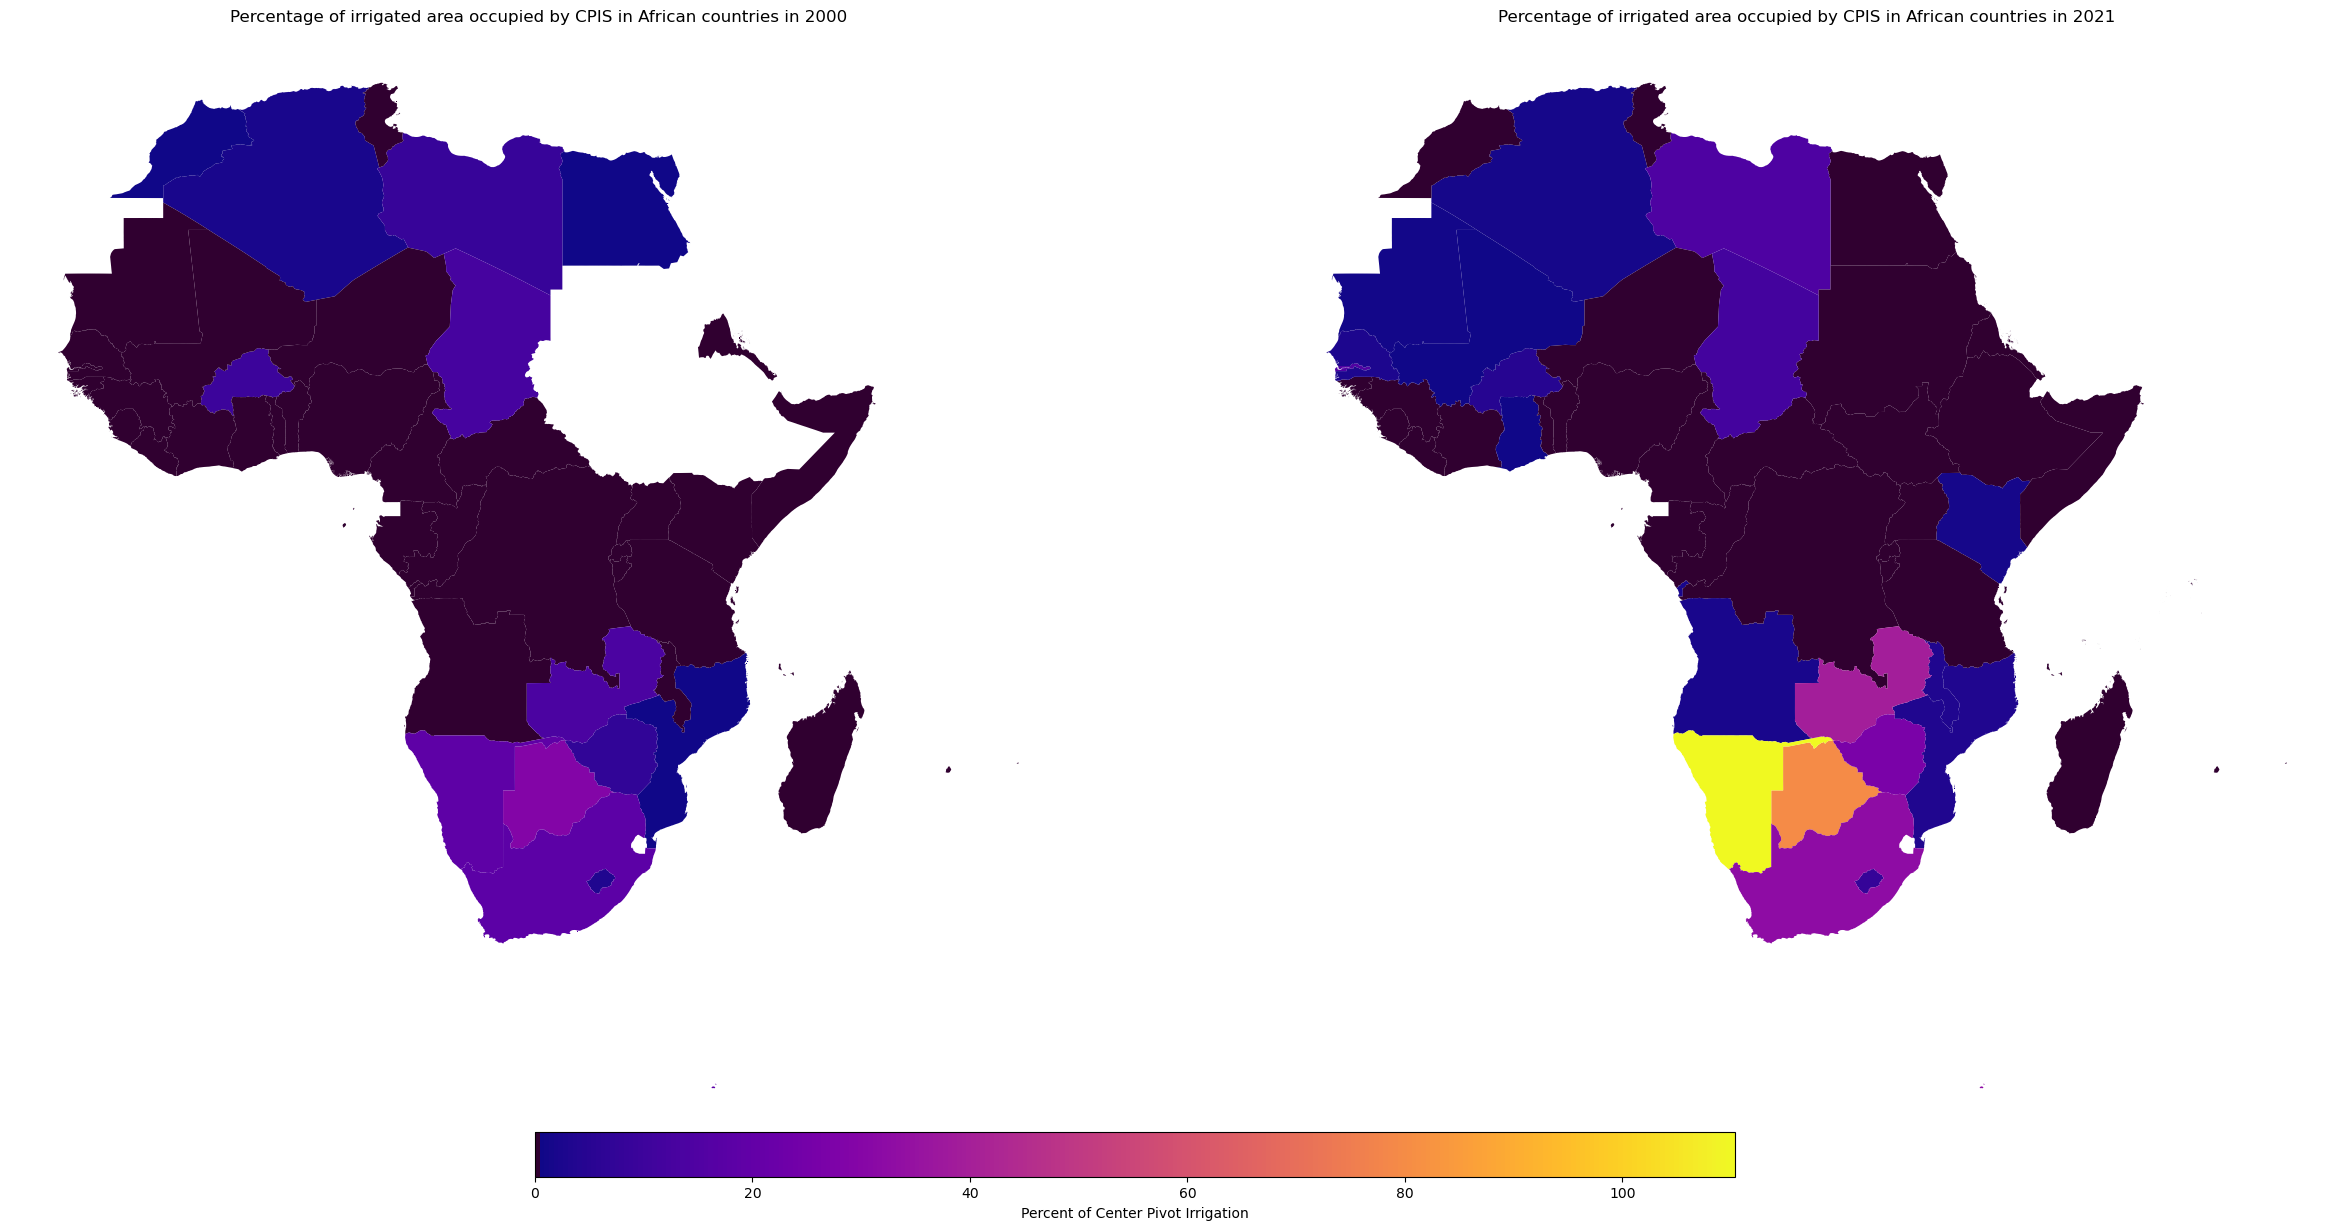

In [39]:
# Custom colormap: dark purple for zero values, viridis otherwise
viridis = plt.colormaps.get_cmap('plasma')
newcolors = viridis(np.linspace(0, 1, 256))
dark_purple = np.array([48/255, 0/255, 48/255, 1]) 
newcolors[0, :] = dark_purple  
custom_cmap = ListedColormap(newcolors)

# plot the merged map
fig, ax = plt.subplots(1, 2, figsize=(30,15), sharex=True, sharey=True)

# plot the 2000 data
merged_geo_data_2000.plot(column='Percent_CPIS', ax=ax[0], legend=False, 
                 cmap = custom_cmap, vmin = 0, vmax = max_value)

# Title the 2000 plot
ax[0].set_title("Percentage of irrigated area occupied by CPIS in African countries in 2000")
ax[0].set_axis_off()                 

# plot the 2021 data
merged_geo_data_2021.plot(column='Percent_CPIS', ax=ax[1], legend=False, 
                 cmap = custom_cmap, vmin = 0, vmax = max_value)

# Title the 2021 plot
ax[1].set_title("Percentage of irrigated area occupied by CPIS in African countries in 2021")
ax[1].set_axis_off()

# Add legend
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03]) 
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=Normalize(vmin=0, vmax=max_value))
sm._A = []  # Trick to enable creation of a color bar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Percent of Center Pivot Irrigation")

plt.show()
